# COMP90051 Workshop 4
## Perceptron
***
In this worksheet, we'll implement the perceptron (a building block of neural networks) from scratch. 
Our key objectives are:

* to review the steps involved in the perceptron training algorithm, 
* to assess how the perceptron behaves in two distinct scenarios (separable vs. non-separable data).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### 1. Synthetic data set
We'll use the built-in `make_classification` function from `sklearn` to generate a synthetic binary classification data set.
The main advantage of using synthetic data is that we have complete control over the distribution. 
This is useful for studying machine learning algorithms under specific conditions.
In particular, we'll be varying the *degree of separability* between the two classes by adjusting the `class_sep` parameter below.
To begin, we'll work with a data set that is almost linearly separable (with `class_sep = 2`).

**Note:** In this worksheet we deviate from the standard `0`/`1` encoding for binary class labels used in `sklearn`. 
We use `-1` in place of `0` for the "negative" class.
This matches the presentation in lectures and makes the gradient descent update simpler to implement.

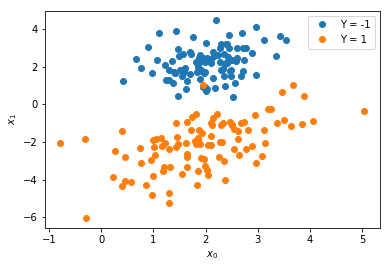

In [2]:
class_sep = 2 
#class_sep = 0.5 # uncomment this later

from sklearn.datasets import make_classification
X, Y = make_classification(n_samples=200, n_features=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, flip_y=0,
                           class_sep=class_sep, random_state=1)
Y[Y==0] = -1 # encode "negative" class using -1 rather than 0
plt.plot(X[Y==-1,0], X[Y==-1,1], "o", label="Y = -1")
plt.plot(X[Y==1,0], X[Y==1,1], "o", label="Y = 1")
plt.legend()
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.show()

**Question:** Is the perceptron a suitable classifier for this data set?

**Answer:** *Strictly speaking, the perceptron is only guaranteed to converge to a "reasonable" solution if the data is linearly seperable.
This data is not quite linearly seperable, so one could argue that the perceptron is unsuitable.*
  
In preparation for training and evaluating a perceptron on this data, we randomly partition the data into train/test sets.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(X_train.shape[0], X_test.shape[0]))

Training set has 134 instances. Test set has 66 instances.


### 2. Definition of the perceptron

Recall from lectures that a perceptron is a binary classifier which maps an input vector $\mathbf{x}$ to a binary ouput given by
$$
\begin{align*}
f(\mathbf{x}; \mathbf{w}, b) &= \begin{cases}
    1 & \mathrm{if} \ s(\mathbf{x}; \mathbf{w}, b) \geq 0, \\
    -1 & \mathrm{otherwise},
\end{cases}
\end{align*}
$$
where $s(\mathbf{x}; \mathbf{w}, b) = \mathbf{w} \cdot \mathbf{x} + b$. 
Here $\mathbf{w}$ is a vector of weights (one for each feature) and $b$ is the bias term.

Let start by implementing the weighted sum function $s(\mathbf{x}; \mathbf{w}, b)$ below. 

In [4]:
def weighted_sum(X, w, b):
    """
    Returns an array containing the weighted sum s(x) for each instance x in the feature matrix
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    w : numpy array, shape: (n_features,)
        weights vector
    b : float
        bias term
    """
    return np.dot(X, w) + b # fill in

def predict(X, w, b):
    """
    Returns an array containing the predicted binary labels (-1/1) for each instance in the feature matrix
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    w : numpy array, shape: (n_features,)
        weights vector
    b : float
        bias term
    """
    return np.where(weighted_sum(X, w, b) >= 0, 1, -1)

### 3. Perceptron training algorithm
We're now going to implement the perceptron training algorithm presented in lectures.
The algorithm is essentially an application of *sequential gradient descent* (a.k.a. *online stochastic gradient descent*) to minimise the following empirical loss:
$$
L[\mathbf{w}, b] = \frac{1}{n} \sum_{i = 1}^{n} \max(0, -y \cdot s(\mathbf{x}; \mathbf{w}, b))
$$
It's *sequential* in that the weights/bias are updated for each training instance—one at a time.
After iterating through all of the training instances, we say that we've completed an *epoch*.
Typically, multiple epochs are required to get close to the optimal solution.

Let's now write a function called `train` which implements sequential gradient descent.
For your reference, the function should implement the following pseudocode:

> repeat $n_\mathrm{epochs}$ times

> >   for each $(\mathbf{x}, y)$ pair in the training set

> > > if the model prediction $\hat{y} = f(\mathbf{x})$ and $y$ differ, make a weight update

> return $\mathbf{w}$ and $b$

**Note:** the weight update in the inner-most loop is given by $\mathbf{w} \gets \mathbf{w} + \eta y  \mathbf{x}$ and $b \gets b + \eta y$.

In [5]:
def train(X, Y, n_epochs, w, b, eta=0.1):
    """
    Returns updated weight vector w and bias term b
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    Y : numpy array, shape: (n_instances,)
        target class labels relative to X
    n_epochs : int
        number of epochs (full sweeps through X)
    w : numpy array, shape: (n_features,)
        initial guess for weights vector
    b : float
        initial guess for bias term
    eta : positive float
        step size (default: 0.1)
    """
    for t in range(n_epochs):
        for i in range(X.shape[0]):
            yhat = predict(X[i,:], w, b) # fill in
            if yhat != Y[i]:
                w += eta * Y[i] * X[i,:] # fill in
                b += eta * Y[i] # fill in
    return w, b

Test your implementation by running it for 5 epochs.
You should get the following result for the weights and bias term:
`w = [ 0.26746342 -0.96011853]; b = -0.2`

In [6]:
# Initialise weights and bias to zero
w = np.zeros(X.shape[1]); b = 0.0

w, b = train(X_train, Y_train, 5, w, b)
print("w = {}; b = {}".format(w, b))

w = [ 0.26746342 -0.96011853]; b = -0.2


### 4. Evaluation

Now that we've trained the perceptron, let's see how it performs.

Below we plot the data (training and test sets) along with the decision boundary (which is defined by $\{\mathbf{x}: s(\mathbf{x}; \mathbf{w}, b) = 0$\}).

**Note:** It's not necessary to understand how the `plot_results` function works.

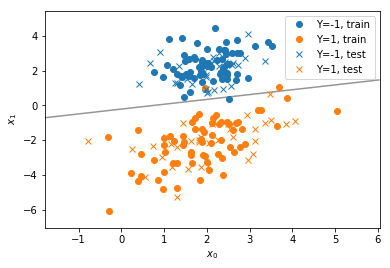

In [7]:
def plot_results(X_train, Y_train, X_test, Y_test, score_fn, threshold = 0):
    # Plot training set
    plt.plot(X_train[Y_train==-1,0], X_train[Y_train==-1,1], "o", label="Y=-1, train")
    plt.plot(X_train[Y_train==1,0], X_train[Y_train==1,1], "o", label="Y=1, train")
    plt.gca().set_prop_cycle(None) # reset colour cycle

    # Plot test set
    plt.plot(X_test[Y_test==-1,0], X_test[Y_test==-1,1], "x", label="Y=-1, test")
    plt.plot(X_test[Y_test==1,0], X_test[Y_test==1,1], "x", label="Y=1, test")

    # Compute axes limits
    border = 1
    x0_lower = X[:,0].min() - border
    x0_upper = X[:,0].max() + border
    x1_lower = X[:,1].min() - border
    x1_upper = X[:,1].max() + border

    # Generate grid over feature space
    resolution = 0.01
    x0, x1 = np.mgrid[x0_lower:x0_upper:resolution, x1_lower:x1_upper:resolution]
    grid = np.c_[x0.ravel(), x1.ravel()]
    s = score_fn(grid).reshape(x0.shape)

    # Plot decision boundary (where s(x) == 0)
    plt.contour(x0, x1, s, levels=[0], cmap="Greys", vmin=-0.2, vmax=0.2)

    plt.legend()
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.show()
    
plot_results(X_train, Y_train, X_test, Y_test, lambda X: weighted_sum(X, w, b))

**Question:** How well does the decision boundary separate the points in the two classes? Where do you think the decision boundary should go? 

**Answer:** *The decision boundary is acceptable for `class_sep=2`, but very poor for `class_sep=0.5`.*

To evaluate the perceptron quantitatively, we'll use the error rate (proportion of misclassified instances).
The error rate is a reasonable evaluation measure to use for this data since the classes are well balanced.

Complete the `evaluate` function below.

In [8]:
def evaluate(X, Y, w, b):
    """
    Returns the proportion of misclassified instances (error rate)
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    Y : numpy array, shape: (n_instances,)
        target class labels relative to X
    w : numpy array, shape: (n_features,)
        weights vector
    b : float
        bias term
    """
    return np.mean(predict(X, w, b) != Y) # fill in

print(evaluate(X_train, Y_train, w, b))

0.022388059701492536


The code block above computes the error rate on the training data, which is not a good idea in general. (Why?)

Compute the error rate on the test set instead.

In [9]:
print(evaluate(X_test, Y_test, w, b)) # fill in

0.0


**Question:** How does this compare to the error on the training set? Is it what you expected?

**Answer:** *The error on the test set is actually smaller than the error on the training set (for `class_sep=2`). This suggests we may not have a problem with overfitting (but it's difficult to say for such a small sample size).*

Let's now examine how the train/test error rates vary as a function of the number of epochs.
Note that careful tuning of the learning rate is needed to get sensible behaviour.
Setting $\eta(t) = \frac{1}{1+t}$ where $t$ is the epoch number often works well.

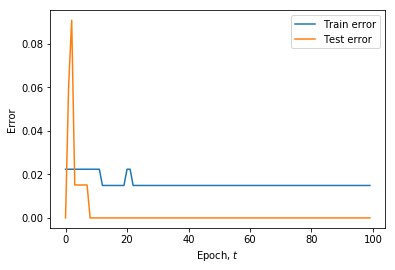

In [10]:
w_hat = np.zeros(X_train.shape[1]); b_hat = 0
n_epochs = 100

# Initialize arrays to store errors for each epoch
train_error = np.empty(n_epochs)
heldout_error = np.empty(n_epochs)

for t in range(n_epochs):
    # here we use a learning rate, which decays with each epoch
    eta = 1./(1+t)
    w_hat, b_hat = train(X_train, Y_train, 1, w_hat, b_hat, eta=eta)    
    train_error[t] = evaluate(X_train, Y_train, w_hat, b_hat)
    heldout_error[t] = evaluate(X_test, Y_test, w_hat, b_hat)

plt.plot(train_error, label = 'Train error')
plt.plot(heldout_error, label = 'Test error')
plt.legend()
plt.xlabel('Epoch, $t$')
plt.ylabel('Error')
plt.show()

**Question:** Does the test error track the training error closely? 

**Answer:** *Yes, the train/test errors are quite close. This suggests we may not have a problem with overfitting.*

**Question:** Has the model changed significantly after training for more epochs (i.e. more than 5)? You can plot the new decision boundary by running the code block below.

**Answer:** *The answer depends on the data set. For `class_sep=2` the model is relatively stable and converges quite rapidly. However for `class_sep=0.5`, the model is highly unstable.*

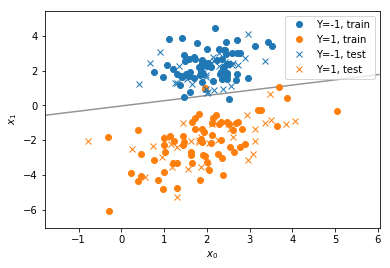

In [11]:
plot_results(X_train, Y_train, X_test, Y_test, lambda X: weighted_sum(X, w_hat, b_hat))

### 5. Repeat with class overlap
By now you've probably concluded that the perceptron performs well on this data (`class_sep=2`), which is to be expected as it's roughly linearly separable. 
However, we know (from lectures) that the perceptron can fail on non-linearly separable data.
To test this scenario, re-generate the synthetic data set with `class_sep=0.5` and repeat Sections 2–4.

**Question:** What do you find? Pay particular attention to plot of the error error vs. training epochs. Do you notice anything unusual?

**Answer:** As mentioned in the previous answer, the model becomes highly unstable—the optimisation algorithm doesn't really converge to a good "approximate" solution. As a result, the train/test errors fluctuate wildly.

### 6. Comparison with logistic regression
We've seen that the perceptron is not robust to binary classification problems with overlapping classes. 
But how does logistic regression fare in this case?

Run the code block below to fit a logistic regression model using `sklearn`. 
You may wish to switch off regularisation (alter the `C` parameter) for a fairer comparison with the perceptron.

In [12]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's plot the decision boundary.

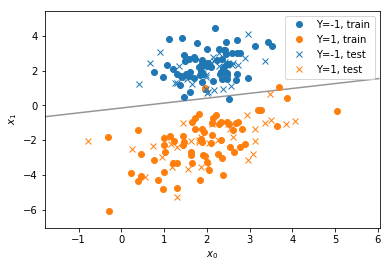

In [13]:
plot_results(X_train, Y_train, X_test, Y_test, lambda X: clf.decision_function(X))

**Question:** How does the logistic regression classifier compare to the perceptron?

**Answer:** *The logistic regression classifier seems to produce a more reasonable "approximate" solution in the presence of class overlap. Note that the support vector machine (formerly known as the perceptron of optimal stability) was designed to address this problem.*

**Question:** Compute the error rate for the logistic regression classifier and compare it to the error rate for the perceptron (for `class_sep=0.5`). *Hint: you may wish to use `clf.score(...)`*

**Answer:** The error rate is lower for logistic regression (around 0.23). The error rate for the perceptron fluctuates, but never seems to reach a comparably low value.

In [14]:
1.0 - clf.score(X_test, Y_test) # fill in

0.0